In [ ]:
#download the dataset
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
!cd data && unzip PennFudanPed.zip

--2024-08-23 06:02:56--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  59.0MB/s    in 0.9s    

2024-08-23 06:02:57 (59.0 MB/s) - ‘data/PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPe

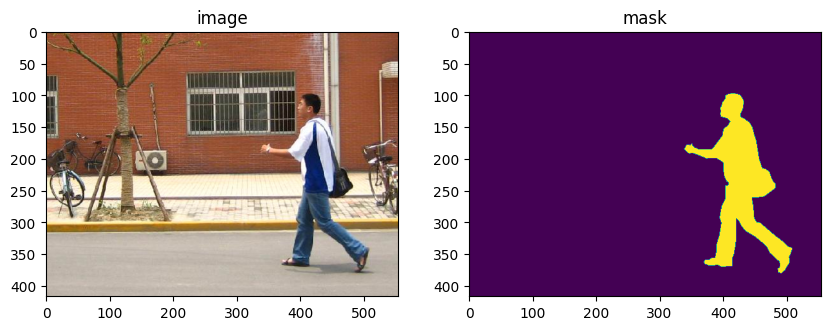

In [ ]:
#visualize an sample
import matplotlib.pyplot as plt
from torchvision.io import read_image
image = read_image("/content/data/PennFudanPed/PNGImages/FudanPed00020.png")
mask = read_image("/content/data/PennFudanPed/PedMasks/FudanPed00020_mask.png")
plt.figure(figsize=(10,7))
plt.subplot(121)
plt.title("image")
plt.imshow(image.permute(1,2,0))
plt.subplot(122)
plt.title("mask")
plt.imshow(mask.permute(1,2,0))

In [ ]:
#import libraries
import os
import torch
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


In [ ]:
!pip install --upgrade torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.7 kB)
  Using cached nvidia_nvjitlink_cu12-12.6.20-py3-none-manyl

In [ ]:
#initialise the dataset
class PennFudanDataset(torch.utils.data.Dataset):
  def __init__(self,root,transforms):
    self.root=root
    self.transforms = transforms
    #load images files and sort them to ensure that they are aligned
    self.imgs = list(sorted(os.listdir(os.path.join(root,"PNGImages"))))
    self.masks = list(sorted(os.listdir(os.path.join(root,"PedMasks"))))

  def __getitem__(self,idx):
    #load image and set path to img in folder
    img_path = os.path.join(self.root,"PNGImages",self.imgs[idx])
    mask_path = os.path.join(self.root,"PedMasks",self.masks[idx])
    img = read_image(img_path)
    mask = read_image(mask_path)

    #instances are in diff colors,which represents different colors
    obj_ids = torch.unique(mask)
    obj_ids = obj_ids[1:]
    num_objs = len(obj_ids)

    #split the color encoded mask into a set of binary masks
    masks = (mask == obj_ids[:,None,None]).to(dtype=torch.uint8)

    #get bbox coordinates for each mask
    boxes = masks_to_boxes(masks)

    labels = torch.ones((num_objs),dtype=torch.int64)

    image_id = idx

    area = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])#width*height

    iscrowd = torch.zeros((num_objs),dtype=torch.int64)

    #wrap sample and target to tv_tensor()
    img = tv_tensors.Image(img)
    target={}
    target["boxes"] = tv_tensors.BoundingBoxes(boxes,format="XYXY",canvas_size=F.get_size(img))
    target["masks"]=tv_tensors.Mask(masks)
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"]=area
    target["iscrowd"]=iscrowd

    if self.transforms is not None:
      img,target = self.transforms(img,target)
    return img,target

  def __len__(self):
    return len(self.imgs)

In [ ]:
#create an model - finetuning from pre trained model

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
  #load the model
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
  #get in feature
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  #replace the pre trainned head with the new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)

  #get in_features for mask classifier
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256

  #replace the mask predictor with new one
  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                     hidden_layer,
                                                     num_classes)
  return model

In [ ]:
#helper functiions
#helper functions
import os
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

0

In [ ]:
#helper function for data augmentation/transforms
from torchvision.transforms import v2 as T
def get_transform(train):
  transforms = []
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  transforms.append(T.ToDtype(torch.float,scale=True))
  #transforms.append(T.Resize((224, 224)))  # Resize images to a common size
  transforms.append(T.ToPureTensor())
  return T.Compose(transforms)

In [ ]:
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13905 sha256=6d766dde1723ef3649db1814a8d44c9d573ecb91df2ededc4cad7148c37ba91d
  Stored in directory: /root/.cache/pip/wheels/b8/39/f5/9d0ca31dba85773ececf0a7f5469f18810e1c8a8ed9da28ca7
Successfully built utils


In [ ]:
#testing forward() method

import utils
from torch.utils.data.dataloader import default_collate
import torch
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset("data/PennFudanPed",get_transform(train=True))
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=2,
                                         shuffle=True,
                                         collate_fn = utils.collate_fn)
#for training
images,targets = next(iter(dataloader))
images = list(image for image in images)
targets = [{k : v for k, v in t.items()} for t in targets]
output = model(images,targets)
print(output)
#for inference
model.eval()
x = [torch.rand(3,300,400),torch.rand(3,500,400)]
predictions = model(x)
print(predictions[0])

{'loss_classifier': tensor(0.0300, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0224, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0088, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0035, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [ ]:
#main function
from engine import train_one_epoch,evaluate

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 2

dataset = PennFudanDataset('data/PennFudanPed',get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed',get_transform(train=False))

#split the data
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset,indices[:-50])
dataset_test = torch.utils.data.Subset(dataset,indices[-50:])

#dataloader
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=2,
                                          shuffle=True,
                                          collate_fn = utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test,
                                               batch_size=1,
                                               shuffle=False,
                                               collate_fn = utils.collate_fn)

model = get_model_instance_segmentation(num_classes)

params=[p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params,lr=0.005,momentum=0.9,weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

epochs=2

for epoch in range(epochs):
  train_one_epoch(model,optimizer,data_loader,device,epoch,print_freq=10)
  lr_scheduler.step()
  evaluate(model,data_loader_test,device=device)


Epoch: [0]  [ 0/60]  eta: 0:47:43  lr: 0.000090  loss: 3.2573 (3.2573)  loss_classifier: 0.7303 (0.7303)  loss_box_reg: 0.2727 (0.2727)  loss_mask: 2.2265 (2.2265)  loss_objectness: 0.0228 (0.0228)  loss_rpn_box_reg: 0.0049 (0.0049)  time: 47.7250  data: 0.0446
Epoch: [0]  [10/60]  eta: 0:34:33  lr: 0.000936  loss: 1.6022 (1.9901)  loss_classifier: 0.5030 (0.4473)  loss_box_reg: 0.2584 (0.2679)  loss_mask: 0.6526 (1.2424)  loss_objectness: 0.0173 (0.0201)  loss_rpn_box_reg: 0.0092 (0.0124)  time: 41.4736  data: 0.0507
Epoch: [0]  [20/60]  eta: 0:31:19  lr: 0.001783  loss: 0.8548 (1.3921)  loss_classifier: 0.2019 (0.3215)  loss_box_reg: 0.2216 (0.2471)  loss_mask: 0.3781 (0.7916)  loss_objectness: 0.0123 (0.0188)  loss_rpn_box_reg: 0.0092 (0.0132)  time: 46.9578  data: 0.0624
Epoch: [0]  [30/60]  eta: 0:23:47  lr: 0.002629  loss: 0.6143 (1.1264)  loss_classifier: 0.1215 (0.2506)  loss_box_reg: 0.1990 (0.2349)  loss_mask: 0.2457 (0.6121)  loss_objectness: 0.0073 (0.0153)  loss_rpn_box_re

KeyboardInterrupt: 

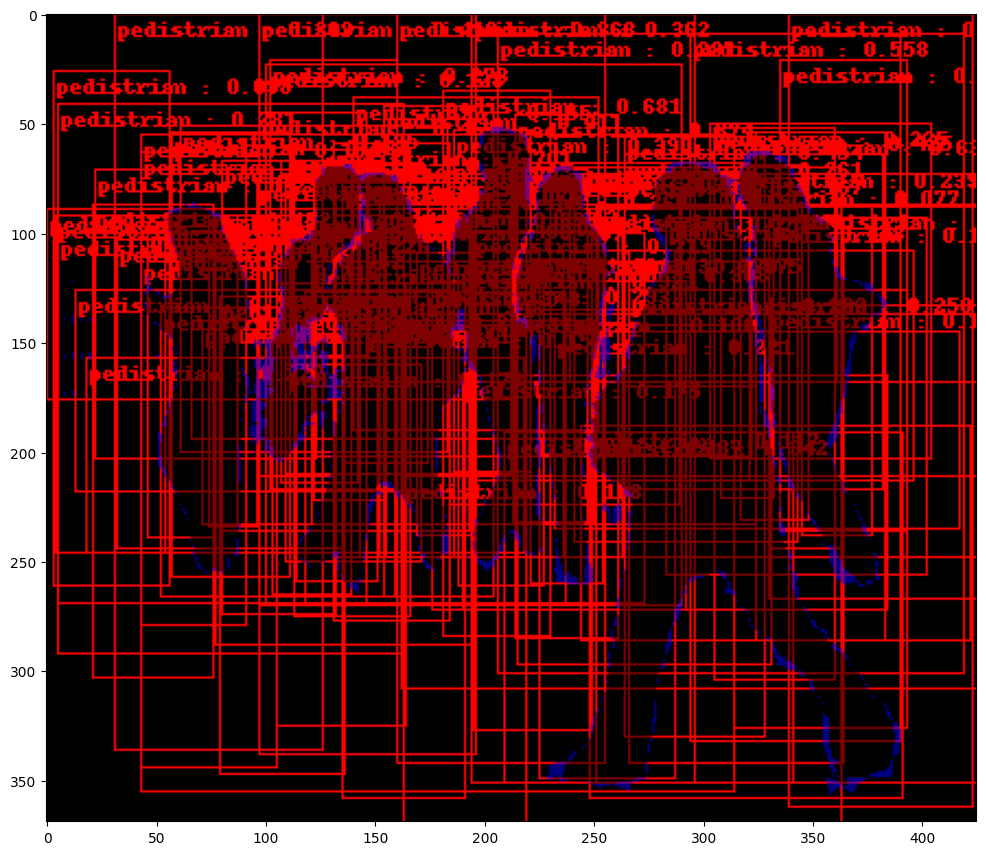

In [ ]:
#evaluate and visualize the data
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes,draw_segmentation_masks

image = read_image("/content/data/PennFudanPed/PNGImages/FudanPed00025.png")
eval_transform = get_transform(train=False)
model.eval()
with torch.no_grad():
  original_image = image.clone()
  x = eval_transform(image)
  x = x[:3,...].to(device)
  predictions = model([x,])#model expects a batch so img is passed in list
  pred = predictions[0]

#normalization f image
image = (255 * (image-image.min()) / (image.max() - image.min())).to(torch.uint8)

image=image[:3,...]
pred_labels = [f"pedistrian : {score:.3f}" for label,score in zip(pred["labels"],pred["scores"])]

#converting bbox coordinates(float -> int)
pred_boxes = pred["boxes"].long()

output_image = draw_bounding_boxes(image,pred_boxes,pred_labels,colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
#masks = T.Resize((image.shape[1], image.shape[2]))(masks) # Resize masks

output_image = draw_segmentation_masks(output_image,masks,alpha=0.5,colors="blue")

plt.figure(figsize=(12,12))
plt.imshow(output_image.permute(1,2,0))